In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

#load all the relevant data

vibe_col = [1,2,3,4,5,6]

normfile = "./Online_data/normal/normal/*.csv"
abnormal_6g = "./Online_data/imbalance/6g/*.csv"
abnormal_10g = "./Online_data/imbalance/10g/*.csv"
abnormal_15g = "./Online_data/imbalance/15g/*.csv"
abnormal_20g = "./Online_data/imbalance/20g/*.csv"
abnormal_25g = "./Online_data/imbalance/25g/*.csv"
abnormal_30g = "./Online_data/imbalance/30g/*.csv"
abnormal_35g = "./Online_data/imbalance/35g/*.csv"


def dataReader(path, cols):
    data_n = pd.DataFrame()
    #each column is a vibration signal, each file has 6 signals, make an array of signals
    for file in glob.glob(path):
        df = pd.read_csv(file, usecols=cols)
        for (columnName, columnData) in df.iteritems():
            #make column data into a dataframe
            df1 = pd.DataFrame(columnData)
            #add the dataframe to the data_n dataframe
            data_n = pd.concat([data_n, df1], axis=1)
    return data_n

datanorm = dataReader(normfile, vibe_col)
data6g = dataReader(abnormal_6g, vibe_col)
data10g = dataReader(abnormal_10g, vibe_col)
data15g = dataReader(abnormal_15g, vibe_col)
data20g = dataReader(abnormal_20g, vibe_col)
data25g = dataReader(abnormal_25g, vibe_col)
data30g = dataReader(abnormal_30g, vibe_col)
data35g = dataReader(abnormal_35g, vibe_col)

print(datanorm.shape)
print(data6g.shape)




(249999, 294)
(249999, 294)


(49, 250000)
(12250, 1000)


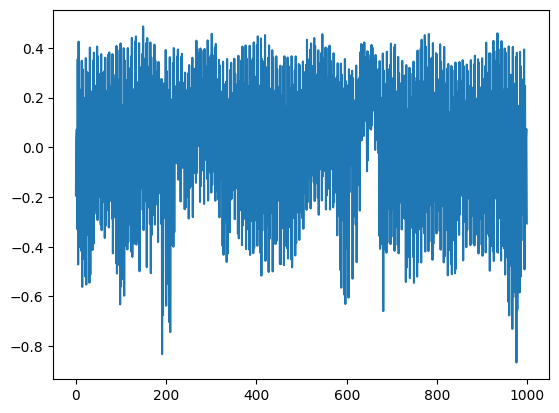

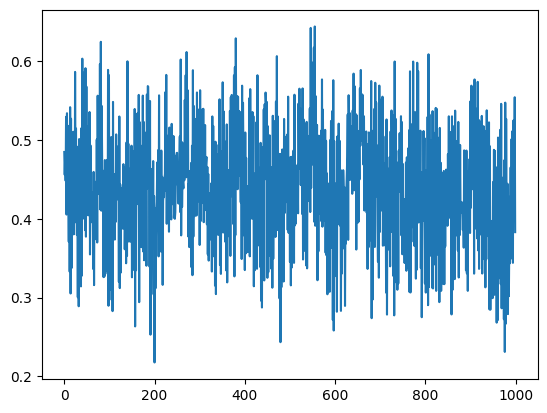

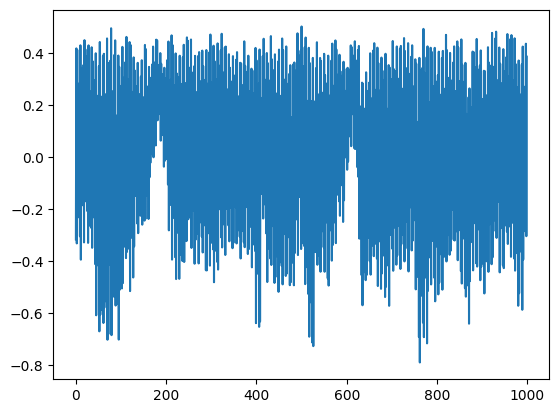

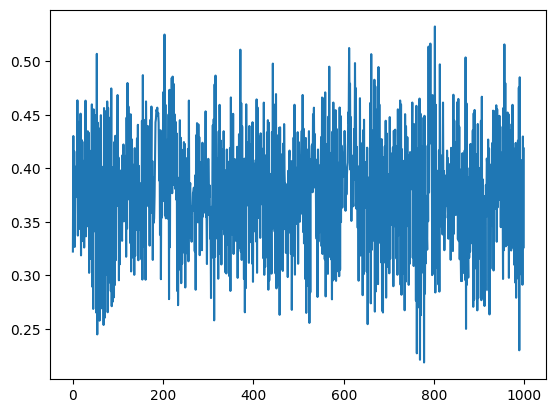

(9800, 1000)
(2450, 1000)


In [117]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

datanormArray = []
data6gArray = []

columnToTest = 1

for i in range(0, datanorm.shape[1], 6):
    signalnorm = datanorm.iloc[:, i+columnToTest]
    #pad the signal with 0s to make it 250000 long
    signalnorm = np.pad(signalnorm, (0, 250000-signalnorm.shape[0]), 'constant')
    datanormArray.append(signalnorm)
    
    
for i in range(0, data6g.shape[1], 6):
    signal6g = data6g.iloc[:, i+columnToTest]
    signal6g = np.pad(signal6g, (0, 250000-signal6g.shape[0]), 'constant')
    data6gArray.append(signal6g)
    

# Step 1a: Preprocess the data
MinMax = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
# scaler = RobustScaler()

dataNorm_np = np.array(datanormArray)
data6g_np = np.array(data6gArray)
print(dataNorm_np.shape)
# Reshape the data into a 3D array (245 captures, 50,000 data points per segment)
duration = 100

data_reshaped = dataNorm_np.reshape(int((dataNorm_np.shape[0] * dataNorm_np.shape[1]) / duration), duration)
print(data_reshaped.shape)
data_reshaped_6g = data6g_np.reshape(int((data6g_np.shape[0] * data6g_np.shape[1]) / duration), duration)

# Preprocess and normalize each segment individually
data_normalized = MinMax.fit_transform(data_reshaped)
data_normalized_6g = MinMax.fit_transform(data_reshaped_6g)
    
#plot graph for normal data before and after scaling
# Plot training & validation loss values
plt.figure()
plt.plot(data_reshaped[0], label='normal Before Scaling')
plt.show()
plt.plot(data_normalized[0], label='normal After Scaling')
plt.show()

plt.plot(data_reshaped_6g[0], label='abnormal Before Scaling')
plt.show()
plt.plot(data_normalized_6g[0], label='abnormal After Scaling')
plt.show()


# Step 1b: Split the data into training and testing sets
data_totrain = data_reshaped[0:int(0.8*data_reshaped.shape[0])]
data_hidden = data_reshaped[int(0.8*data_reshaped.shape[0]):]

data_normalized_totrain = data_normalized[0:int(0.8*data_normalized.shape[0])]
data_normalized_hidden = data_normalized[int(0.8*data_normalized.shape[0]):]  

print(data_normalized_totrain.shape)
print(data_normalized_hidden.shape)

Epoch 1/20
245/245 [==============================] - 3s 13ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 2/20
245/245 [==============================] - 3s 12ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 3/20
245/245 [==============================] - 3s 12ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 4/20
245/245 [==============================] - 3s 12ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/20
245/245 [==============================] - 3s 12ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/20
245/245 [==============================] - 3s 12ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 7/20
245/245 [==============================] - 3s 12ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/20
245/245 [==============================] - 3s 12ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/20
245/245 [==============================] - 3s 12ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/20
245/245 [==============================] - 3s 12ms/step - loss: 0.0017 - val_lo

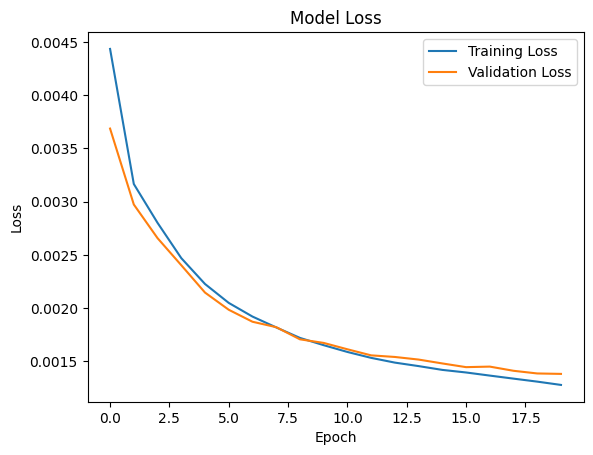

77/77 [==============================] - 0s 4ms/step


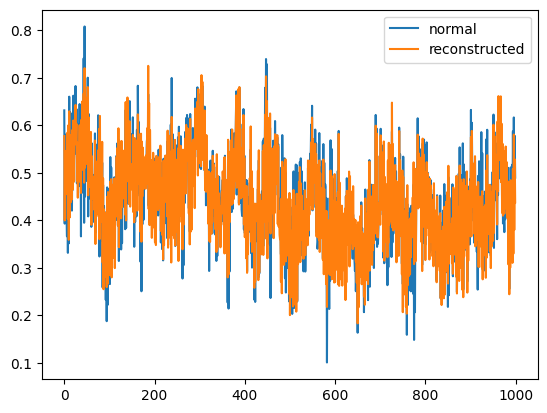

Anomalies in normal data: 1.4693877551020407 %
383/383 [==============================] - 2s 4ms/step


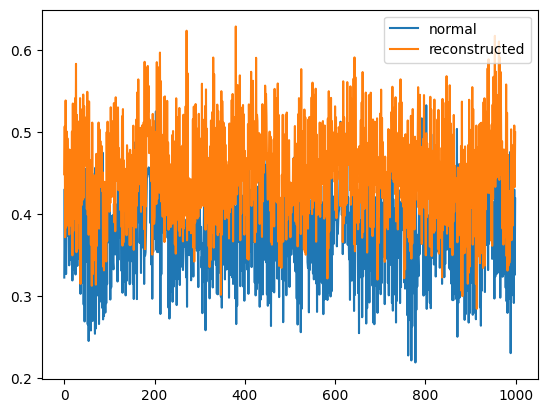

Anomalies in 6g data: 100.0 %


In [123]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.losses import mse as mse_loss
from keras import Sequential


# Step 2: Split the data
X_train, X_test = train_test_split(data_normalized_totrain, test_size=0.2, random_state=42)

# Step 3: Build the autoencoder
input_size = data_normalized_totrain.shape[1]

input_layer = Input(shape=(input_size,))
encoder_layer = Sequential([
    Dense(500, activation='relu'),
    Dense(200, activation='relu'),
    Dense(100, activation='relu')
])
decoder_layer = Sequential([
    Dense(input_size/2, activation='relu'),
    Dense(input_size, activation='sigmoid')
])

encoder_layer = encoder_layer(input_layer)
decoder_layer = decoder_layer(encoder_layer)

autoencoder = Model(inputs=input_layer, outputs=decoder_layer)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode="auto")

# Step 4: Train the autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the autoencoder with the EarlyStopping callback
history = autoencoder.fit(
    X_train, X_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping],
    verbose=1
)


# Step 5: Evaluate the model
reconstructed_data = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructed_data, 2), axis=1)

# Step 6: Set a threshold
threshold = np.percentile(mse, 95)  # Set the threshold to the 95th percentile of the reconstruction errors

# Step 7: Anomaly detection
def is_anomaly(data, model, threshold):
    reconstructed_data = model.predict(data)
    
    plt.figure()
    plt.plot(data[0], label='normal')
    plt.plot(reconstructed_data[0], label='reconstructed')
    plt.legend(loc='upper right')
    plt.show()
    
    # print(reconstructed_data.shape)
    mse = np.mean(np.power(data - reconstructed_data, 2), axis=1)
    return mse > threshold


# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


# Test with a new data point
count_norm = 0
anomalies_normal = is_anomaly(data_normalized_hidden, autoencoder, threshold)

for i in anomalies_normal:
    if i == True:
        count_norm += 1
print("Anomalies in normal data:", (count_norm / anomalies_normal.size) * 100, "%")

# Test 6g data
anomalies_6g = is_anomaly(data_normalized_6g, autoencoder, threshold)

count_6g = 0;
for i in anomalies_6g:
    if i == True:
        count_6g += 1
print("Anomalies in 6g data:", (count_6g / anomalies_6g.size) * 100, "%")
